<a href="https://colab.research.google.com/github/Roshini1845/dr_streamlit_app/blob/main/DR_SEVERITY_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow opencv-python pandas seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set folder paths
train_folder = "/content/drive/MyDrive/train_image"
val_folder = "/content/drive/MyDrive/val_image"
test_folder = "/content/drive/MyDrive/test_image"

# Load CSV files (uploaded directly to Colab, not Drive)
train_csv = pd.read_csv("/content/train_1.csv")
val_csv = pd.read_csv("/content/valid.csv")
test_csv = pd.read_csv("/content/test.csv")

In [ ]:
train_csv['image_path'] = train_csv['id_code'].apply(lambda x: f"{train_folder}/{x}.png")
val_csv['image_path'] = val_csv['id_code'].apply(lambda x: f"{val_folder}/{x}.png")
test_csv['image_path'] = test_csv['id_code'].apply(lambda x: f"{test_folder}/{x}.png")

In [ ]:
def preprocess_image(path, img_size=128):
    img = cv2.imread(path)
    if img is not None:
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0
        return img
    else:
        return np.zeros((img_size, img_size, 3))  # fallback in case of read error

In [ ]:
def load_data(df, img_size=128):
    X = np.array([preprocess_image(p, img_size) for p in df['image_path']])
    y = df['diagnosis'].values
    return X, y

X_train, y_train = load_data(train_csv)
X_val, y_val = load_data(val_csv)
X_test, y_test = load_data(test_csv)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=5)
y_val_cat = to_categorical(y_val, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 classes of DR
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=10, batch_size=32)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 73s 769ms/step - accuracy: 0.4788 - loss: 1.4738 - val_accuracy: 0.4781 - val_loss: 1.3341
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 752ms/step - accuracy: 0.4894 - loss: 1.3080 - val_accuracy: 0.4699 - val_loss: 1.3516
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 747ms/step - accuracy: 0.4993 - loss: 1.3102 - val_accuracy: 0.4699 - val_loss: 1.3339
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 744ms/step - accuracy: 0.4927 - loss: 1.3088 - val_accuracy: 0.4809 - val_loss: 1.3175
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 747ms/step - accuracy: 0.4957 - loss: 1.2912 - val_accuracy: 0.4754 - val_loss: 1.3212
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 734ms/step - accuracy: 0.4905 - loss: 1.3043 - val_accuracy: 0.4781 - val_loss: 1.3058
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 737ms/step - accuracy: 0.4992 - loss: 1.3081 - val_accuracy: 0.4781 - val_loss: 1.3455
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 738ms/step - accuracy: 0.5018 - loss: 1.2982 - val_accu

In [ ]:
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc*100:.2f}%")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.5541 - loss: 1.3715
Test Accuracy: 54.92%
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.55      1.00      0.71       199
           1       0.00      0.00      0.00        30
           2       1.00      0.02      0.04        87
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00        33

    accuracy                           0.55       366
   macro avg       0.31      0.20      0.15       366
weighted avg       0.54      0.55      0.40       366



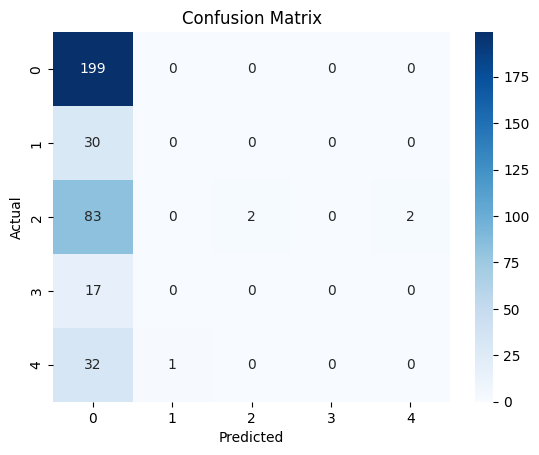

In [ ]:
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.save("dr_model.h5")

Saving e5d56f4f359b.png to e5d56f4f359b.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

🔍 Prediction: Mild
📊 Confidence: 100.00%


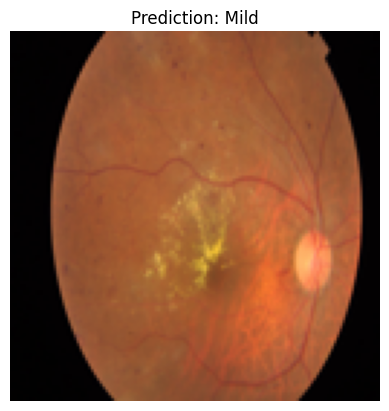

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
from google.colab import files

# Load the model
model = tf.keras.models.load_model("dr_model.h5")

# Class labels
labels = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

# Upload image
uploaded = files.upload()

for fn in uploaded.keys():
    # Load and preprocess image
    img = Image.open(fn).convert("RGB")
    img = img.resize((128, 128))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 128, 128, 3)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction) * 100

    print(f"\n🔍 Prediction: {labels[predicted_class]}")
    print(f"📊 Confidence: {confidence:.2f}%")

    # Show image
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.title(f"Prediction: {labels[predicted_class]}")
    plt.axis('off')
    plt.show()

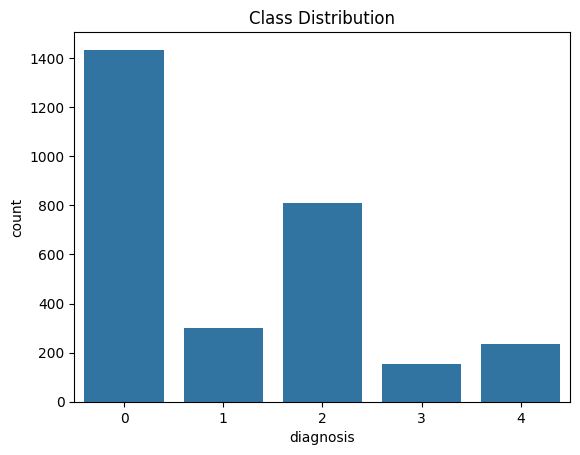

In [ ]:
sns.countplot(x='diagnosis', data=train_csv)
plt.title("Class Distribution")
plt.show()

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False  # Freeze base

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Predict
prediction = model.predict(img_array)[0]

for i, prob in enumerate(prediction):
    print(f"{labels[i]}: {prob * 100:.2f}%")

predicted_class = np.argmax(prediction)
print(f"\n🔍 Final Prediction: {labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
No DR: 22.39%
Mild: 29.91%
Moderate: 15.65%
Severe: 11.26%
Proliferative DR: 20.78%

🔍 Final Prediction: Mild


In [ ]:
model.save("dr_model.h5")

In [ ]:
model.save('dr_model.h5')
from google.colab import files
files.download('dr_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install streamlit

  Using cached streamlit-1.45.0-py3-none-any.whl.metadata (8.9 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached GitPython-3.1.44-py3-none-any.whl.metadata (13 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
Using cached streamlit-1.45.0-py3-none-any.whl (9.9 MB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached GitPython-3.1.44-py3-none-any.whl (207 kB)
Using cached pydeck-0.9.1-py2.py3-none-any.whl (6.9 MB)
Using cached gitdb-4.0.12-py3-none-any.whl (62 kB)
  Attempting uninstall: blinker
    Found existing installation: blinker 1.4
error: uninstall-distutils-installed-package

× Cannot uninstall blinker 1.4
╰─> It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
